In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 토픽모델링: LDA Topic Modeling
- 말뭉치 안에서 단어ᐨ주제ᐨ문서 관계를 중심으로, 문서에 내재된 토픽(주제)을 추출하고, 문서를 분류하는 작업
- LDA( Latent Dirichlet Allocation): 문서의 집합으로부터 어떤 토픽이 존재하는지를 알아내기 위한 알고리즘

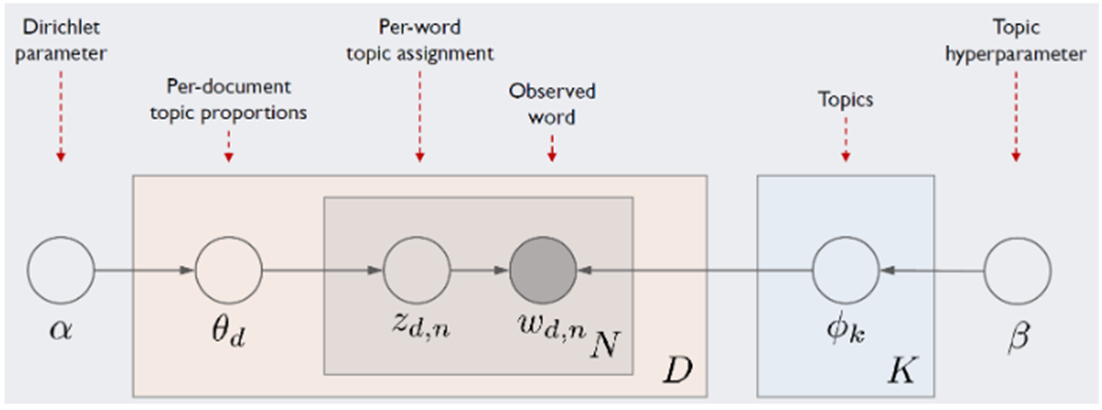



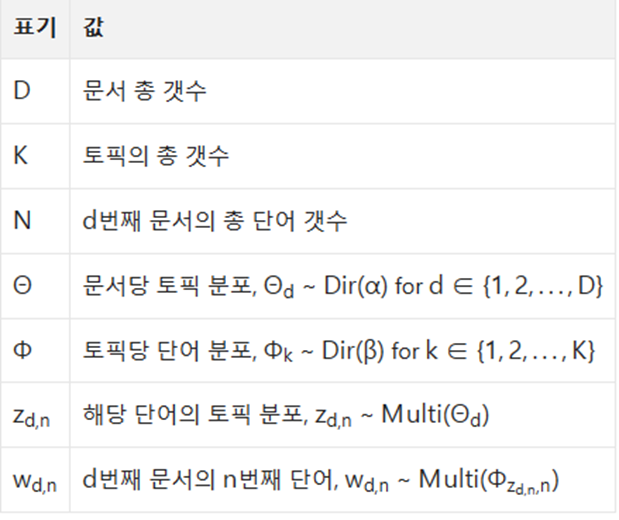














### 참조
* 고려대학교 산업경영공학부 DSBA 연구: Topic Modeling Part 2 (LDA Document generation process), https://www.youtube.com/watch?v=WR2On5QAqJQ
* 고려대학교 산업경영공학부 DSBA 연구: Topic Modeling Part 3 - LDA Inference, https://www.youtube.com/watch?v=iwMSCsiL6wQ&t=4442s
* ratsgo's blog: https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/06/01/LDA/
* 이수안컴퓨터연구소: 토픽 모델링 Topic Modeling, https://www.youtube.com/watch?v=Xt607xhpF6U&t=2s
* https://blog.naver.com/chunjein/220930508590


### 패키지 설치
* tomotopy 사용: LDA + Collapsed Gibbs-Sampling(CGS)
* https://bab2min.github.io/tomotopy/v0.5.1/kr/#tomotopy.LDAModel
* https://bab2min.github.io/tomotopy/

In [ ]:
! pip install tomotopy
! pip install pyldavis
! pip install numpy

### 패키지 불러오기: error 발생하면 런타임 다시 시작하고 실행

In [ ]:
import tomotopy as tp   # 토픽모델링 패키지
import pyLDAvis       # 시각화 패키지
import numpy as np    # 파이썬 계산기
import pandas as pd   # 파이썬 엑셀
from tqdm import tqdm

### 토픽 개수 설정용 함수 설치

In [ ]:
def get_perplexity(docs=[""], min_cf=10, to=31):  #min_cf(collection frequency)=단어 출현빈도의 최솟값
    """docs=["단어,단어,단어","단어,단어,단어","단어,단어,단어"]로 입력. to=포함할 토픽 갯수.
    perplexity와 coherence Dataframe으로 출력"""
    docs = [doc.split(",") if type(doc) == str else [] for doc in docs]
    per_coh=[]
    for i in tqdm(range(2, to)):
        mdl = tp.LDAModel(k=i, alpha=0.1, eta=0.01, min_cf=min_cf, tw=tp.TermWeight.IDF)  #eta = beta에 해당
        for doc in docs:
            try:
                mdl.add_doc(doc)  # 한줄씩 입력해 mdl 만들기
            except:
                mdl.add_doc([""])
        mdl.train(100)
        #print(str(i), "perplexity:", str(mdl.perplexity))
        cohs=[]
        for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
            coh = tp.coherence.Coherence(mdl, coherence=preset)
            average_coherence = coh.get_score()
            coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]
            #print(str(i), 'coherence_{}:'.format(preset), str(average_coherence))
            cohs.append(average_coherence)
            #print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
        per_coh.append([i,mdl.perplexity]+cohs)
        result=pd.DataFrame(per_coh, columns=['topic_n','perplexity','u_mass','c_uci','c_npmi','c_v'])
    return result

### 토픽모델링 실시용 함수

In [ ]:
def topic_model(docs=[""], k=10, min_cf=10, model_save=False, model_html=False):
    """docs=["단어,단어,단어","단어,단어,단어","단어,단어,단어"]로 입력, k=선정된 토픽 갯수 입력,
    model_save=모델 저장하려면 영어 절대경로 입력(C://path/---.bin). model_html=모델 시각화 저장하려면 영어 절대경로 입력(C://path/---.html)
    summary, topic_term, doc_topic 출력. 모델 불러오기: tp.LDAModel.load()"""
    docs = [doc.split(",") if type(doc) == str else [""] for doc in docs]
    mdl = tp.LDAModel(k=k, alpha=0.1, eta=0.01, min_cf=min_cf, tw=tp.TermWeight.IDF) # min_cf: 코퍼스에서 최소 언급 횟수.. 보통 5.. #eta = beta에 해당
    for doc in docs:
        try:
            mdl.add_doc(doc)  # 한줄씩 입력해 mdl 만들기
        except:
            mdl.add_doc([""])
    mdl.burn_in = 100
    mdl.train(0)
    for i in tqdm(range(0, 1000, 10)):    # 100회 iteration
        mdl.train(10)
    summary=mdl.summary()
    if model_save:
        mdl.save(model_save)
    else:
        pass
    topic_term=pd.DataFrame([mdl.get_topic_words(k,top_n=30) for k in range(mdl.k)], \
                            index=["topic"+str(i) for i in range(k)], \
                            columns=["keyword"+str(i) for i in range(30)]).T
    docs_topic = []
    for i, doc in enumerate(mdl.docs):
        t=list(doc.get_topic_dist())
        t.append(t.index(max(t)))
        t.append(docs[i][0])
        docs_topic.append(t)
    doc_topic=pd.DataFrame(docs_topic, columns=["topic"+str(i) for i in range(k)]+["소속토픽","문서첫단어"])
    # 모델 시각화
    topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
    doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
    doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
    vocab = list(mdl.used_vocabs)
    term_frequency = mdl.used_vocab_freq
    prepared_data = pyLDAvis.prepare(
        topic_term_dists,
        doc_topic_dists,
        doc_lengths,
        vocab,
        term_frequency,
        start_index=0,  # tomotopy starts topic ids with 0, pyLDAvis with 1
        sort_topics=False)  # IMPORTANT: otherwise the topic_ids between pyLDAvis and tomotopy are not matching!
    if model_html:
        pyLDAvis.save_html(prepared_data, model_html)
    else:
        pass
    return [summary, topic_term, doc_topic]  # csv로 저장. excel 안됨.

### 전처리 실시용 함수

In [ ]:
# 함수화: 명사 추출과 주요 품사 추출 수행

! pip install kiwipiepy

import re
from kiwipiepy import Kiwi
kiwi = Kiwi()

def kiwi_tokenize(txt, nouns=True, remove1=False, stopwords=[]):
    '''문자열 txt를 받아 kiwi로 형태소 추출: nouns=명사만 추출 여부, remove1=1음절 토큰 제외 여부, stopwords=불용어 리스트 '''
    try:
        # 정제(cleaning): 비문자숫자 등 노이즈 제거
        txt1=re.sub(r"[^\s가-힣a-zA-Z0-9]", " ", txt)   # re.sub: 문자열 부분 교체. r은 정규표현식 사용한다는 표시.
                                                        # "[^ 가-힣a-zA-Z1-9]"는 한글 영어 숫자 이외의 문자열 의미.
                                                        # txt1=txt1.replace("X", " "):  특정 단어만 삭제할 때에는 replace 함수로 간단히 실행
        # 토큰화(tokenization): 형태소 추출
        morphs=kiwi.tokenize(txt1)
        morphs_all=[m[0] for m in morphs]                # 모든 품사에 해당하는 형태소 모두 추출
        morphs_select=['NNG', 'NNP', 'NP', 'NR', 'VV', 'VX', 'VCP', 'VCN', 'VA','VA-I', 'MM', 'MAG']  # 일반명사, 고유명사, 용언(동사, 형용사 등), 관형사, 일반부사 # 품사 분류표 참조
        # 명사 추출(nou extraction) 여부 선택
        if nouns==True:
            token_lst=[m[0] for m in morphs if m[1] in morphs_select[:4]]
        else:
            token_lst=[m for m in morphs if m[1] in morphs_select]
            # stemming(어간 추출, 동사-형용사 등 용언의 원형 복구) 적용
            token_lst=[m[0]+'다' if m[1].startswith('V') else m[0] for m in token_lst]
        # 1음절 토큰 제외 여부 선택
        if remove1==True:
            token_lst=[t for t in token_lst if len(t)>1 ]
        else:
            pass
        # 불용어(stopwords) 적용: 제외해야 할 토큰들의 집합
        token_lst=[t for t in token_lst if t not in stopwords]
    except:
        token_lst=[]
    return ','.join(token_lst)

### 데이터 준비

In [ ]:
import pandas as pd
df=pd.read_excel('/content/drive/MyDrive/2024_1_class/nnews_선거_KBS_20240401_nouns.xlsx')
df=pd.read_excel('/content/drive/MyDrive/518/518망언_네이버댓글_20000501_20240531.xlsx')
df.info()

df['title_text']=df['title']+df['text']
df1=df[~df['title_text'].isnull()]  # 결측치 제거
df1.info()

df1=df[~df['contents'].isnull()]  # 결측치 제거
df1.info()

### 명사 추출

In [ ]:
from tqdm import tqdm

result=[]
for sent in tqdm(list(df1['contents'][:])):
    try:
        nouns=kiwi_tokenize(sent, nouns=True, remove1=True, stopwords=[])
        result.append(nouns)
    except:
        result.append(None)
df1['contents_nouns']=result
df1.to_excel('/content/drive/MyDrive/518/518망언_네이버댓글_nouns_20000501_20240531.xlsx') # 필요하면 저장

### 토픽 개수 정하기

 perplexity 낮고 cohrence 높은 지점



In [ ]:
df['contents_nouns']
mydocs=df1['title_text_nouns'].tolist()

mydocs=df1['contents_nouns'].tolist()
result_percoh = get_perplexity(docs=mydocs, min_cf=20, to=31)

### 저장

In [ ]:
result_percoh.to_excel("/content/tm_percoh.xlsx")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=[10, 4])
plt.plot(result_percoh['topic_n'], result_percoh['perplexity'])
plt.title('perplexity')
plt.xticks(range(1,31))
plt.show()
plt.figure(figsize=[10, 4])
plt.plot(result_percoh['topic_n'], result_percoh['c_v'])
plt.title('c_v')
plt.xticks(range(1,31))
plt.show()

### 토픽모델링 실시

In [ ]:
mydocs=df1['contents_nouns'].tolist()
k=17
mymodel="/content/tm.bin"
myhtml="/content/tm.html"
summary, topic_term, doc_topic = topic_model(docs=mydocs, k=k, min_cf=20, model_save=mymodel, model_html=myhtml)

### topic-term, topic-distribution 파일 생성




In [ ]:
topic_term.to_excel("/content/result_topicterm.xlsx")
df1.index=list(range(len(df1)))
df_doc_topic=pd.concat([df1, doc_topic], axis=1)
df_doc_topic.to_excel("/content/result_topicdist.xlsx")

### 토픽별 상위 30위 문장 추출

In [ ]:
import pandas as pd
import numpy as np

# 소속토픽 찾고 확률 정리
topic_columns = [col for col in df_doc_topic.columns if col.startswith('topic')] # 토픽 컬럼을 식별하기 위한 패턴
df_doc_topic['소속토픽확률'] = df_doc_topic[topic_columns].max(axis=1) # 소속토픽 확률 찾기

# 각 소속 토픽별로 확률 값 상위 30위 문장 추출
result_df = df_doc_topic.groupby('소속토픽').apply(lambda x: x.nlargest(30, '소속토픽확률')).reset_index(drop=True)
result_df['순위'] = result_df.groupby('소속토픽').cumcount() + 1 # 순위 추가

# 필요한 컬럼만 선택해 DataFrame 생성
result_df1 = result_df[['소속토픽', '순위', 'contents', '소속토픽확률']]
result_df1.to_excel("/content/result_topicdistcases.xlsx")